样本量(合并后): 121
        date  unemployment  vacancies  gdp_index  cpih  interest_rate
0 2015-09-01           5.2        741       89.9   0.2            0.5
1 2015-10-01           5.1        741       90.4   0.2            0.5
2 2015-11-01           5.1        746       90.4   0.4            0.5
3 2015-12-01           5.1        712       90.4   0.5            0.5
4 2016-01-01           5.1        735       90.9   0.6            0.5
样本量(变换后): 120

===== OLS (non-robust) =====
                             OLS Regression Results                            
Dep. Variable:     unemployment_change   R-squared:                       0.422
Model:                             OLS   Adj. R-squared:                  0.407
Method:                  Least Squares   F-statistic:                     28.28
Date:                 Wed, 28 Jan 2026   Prob (F-statistic):           8.49e-14
Time:                         15:41:36   Log-Likelihood:                -436.97
No. Observations:                  120   A

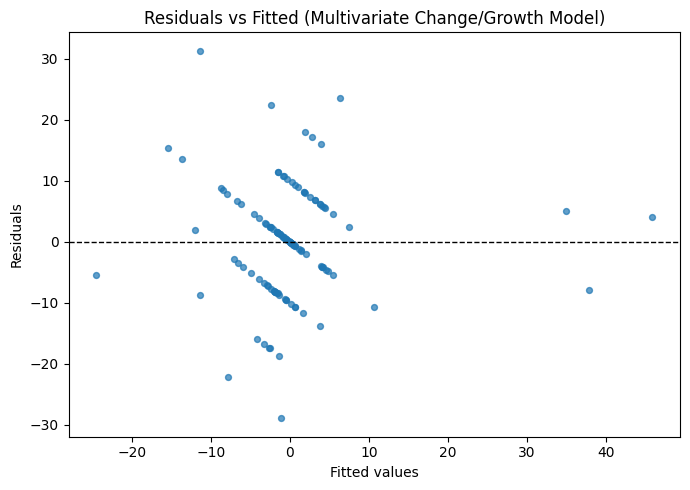

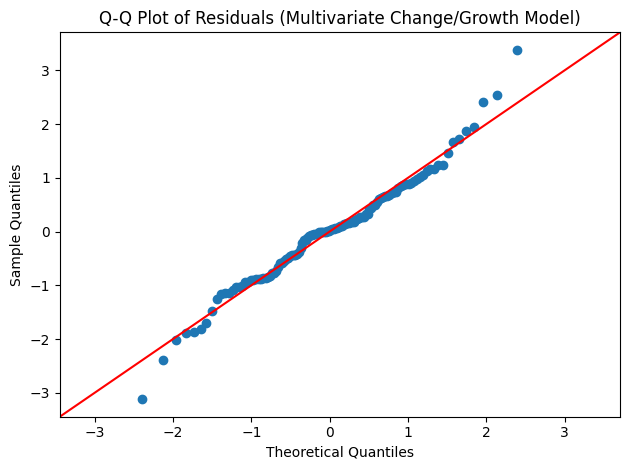


Shapiro-Wilk test:
Statistic = 0.983, p-value = 0.135

Spearman correlation (vacancies_growth vs unemployment_change):
rho = -0.505, p-value = 0.000

已输出建模数据：using_data_csv/多元回归_变化模型_建模数据.csv
图片已保存到 pic/ 文件夹。


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =============================
# 0. 路径 & 输出文件夹
# =============================
PATH_UNEMP = "using_data_csv/失业率（15-25）.csv"
PATH_VAC = "using_data_csv/职位空缺（15-25）.csv"
PATH_GDP = "using_data_csv/GDP指数（15-25）.csv"
PATH_CPIH = "using_data_csv/CPIH消费者物价指数（15-25）.csv"
PATH_RATE = "using_data_csv/银行利率（15-25）.csv"

os.makedirs("pic", exist_ok=True)

# =============================
# 1. 读取数据（统一列名）
# =============================
unemp = pd.read_csv(PATH_UNEMP, parse_dates=["date"]).rename(
    columns={"rate": "unemployment"}
)

vac = pd.read_csv(PATH_VAC, parse_dates=["date"]).rename(
    columns={"value": "vacancies"}
)

gdp = pd.read_csv(PATH_GDP, parse_dates=["date"]).rename(
    columns={"value": "gdp_index"}
)

cpih = pd.read_csv(PATH_CPIH, parse_dates=["date"]).rename(
    columns={"value": "cpih"}
)

rate = pd.read_csv(PATH_RATE, parse_dates=["date"]).rename(
    columns={"value": "interest_rate"}
)

# =============================
# 2. 合并 + 排序
# =============================
df = (
    unemp.merge(vac, on="date", how="inner")
         .merge(gdp, on="date", how="inner")
         .merge(cpih, on="date", how="inner")
         .merge(rate, on="date", how="inner")
         .dropna()
         .sort_values("date")
         .reset_index(drop=True)
)

print(f"样本量(合并后): {len(df)}")
print(df.head())

# =============================
# 3. 构造变化/增长变量（核心）
# =============================
# 失业率：百分点变化（如果原始失业率是 0-1 的比例，这里 *100 变成百分点）
df["unemployment_change"] = df["unemployment"].diff() * 100

# 职位空缺：月度增长率（%）
df["vacancies_growth"] = df["vacancies"].pct_change() * 100

# GDP指数：月度增长率（%）
df["gdp_growth"] = df["gdp_index"].pct_change() * 100

# CPIH：月度通胀率（%）
df["cpih_inflation"] = df["cpih"].pct_change() * 100

# 利率：百分点变化（若利率本来就是百分比点，比如 5.25，这里 diff 就是百分点变化）
df["interest_change"] = df["interest_rate"].diff()

df_ts = df.dropna().copy()
print(f"样本量(变换后): {len(df_ts)}")

# =============================
# 4. 多元回归（变化模型，不含利率）
# unemployment_change = β0
#   + β1 vacancies_growth
#   + β2 gdp_growth
#   + β3 cpih_inflation
# =============================

X = df_ts[[
    "vacancies_growth",
    "gdp_growth",
    "cpih_inflation"
]]

X = sm.add_constant(X)
y = df_ts["unemployment_change"]

model = sm.OLS(y, X).fit()
model_hac = sm.OLS(y, X).fit(
    cov_type="HAC",
    cov_kwds={"maxlags": 6}
)

print("\n===== OLS (non-robust) =====")
print(model.summary())

print("\n===== OLS with Newey-West (HAC) standard errors =====")
print(model_hac.summary())


# =============================
# 5. 共线性检查（VIF）
# =============================
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n===== VIF (multicollinearity check) =====")
print(vif)

# =============================
# 6. 残差诊断（用 non-robust 的残差来画图即可）
# =============================

# 6.1 Residuals vs Fitted
plt.figure(figsize=(7, 5))
plt.scatter(model.fittedvalues, model.resid, alpha=0.7, s=18)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Multivariate Change/Growth Model)")
plt.tight_layout()
plt.savefig("pic/Residuals_vs_Fitted_multivar_change.png", dpi=300, bbox_inches="tight")
plt.show()

# 6.2 Q-Q plot
resid_std = (model.resid - model.resid.mean()) / model.resid.std(ddof=1)
sm.qqplot(resid_std, line="45")
plt.title("Q-Q Plot of Residuals (Multivariate Change/Growth Model)")
plt.tight_layout()
plt.savefig("pic/QQplot_multivar_change.png", dpi=300, bbox_inches="tight")
plt.show()

# 6.3 Shapiro-Wilk
shapiro_test = stats.shapiro(model.resid)
print("\nShapiro-Wilk test:")
print(f"Statistic = {shapiro_test.statistic:.3f}, p-value = {shapiro_test.pvalue:.3f}")

# =============================
# 7. Spearman 相关（可选：看核心关系是否稳）
# =============================
spearman_core = stats.spearmanr(df_ts["vacancies_growth"], df_ts["unemployment_change"])
print("\nSpearman correlation (vacancies_growth vs unemployment_change):")
print(f"rho = {spearman_core.correlation:.3f}, p-value = {spearman_core.pvalue:.3f}")

# =============================
# 8.（可选）把最终建模数据另存，方便写作/复现
# =============================
df_ts_out = df_ts[[
    "date",
    "unemployment_change",
    "vacancies_growth",
    "gdp_growth",
    "cpih_inflation",
    "interest_change"
]].copy()

df_ts_out.to_csv("using_data_csv/多元回归_变化模型_建模数据.csv", index=False, encoding="utf-8-sig")
print("\n已输出建模数据：using_data_csv/多元回归_变化模型_建模数据.csv")
print("图片已保存到 pic/ 文件夹。")

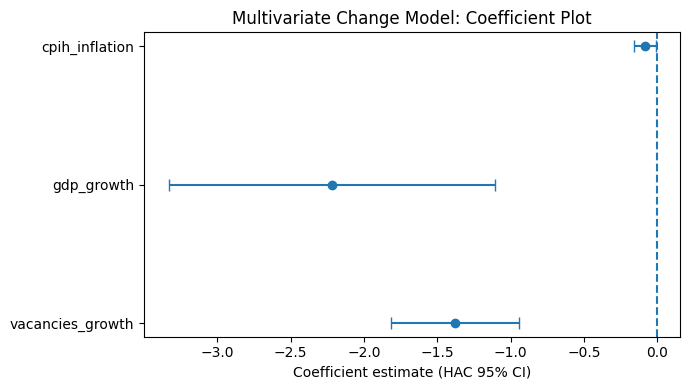

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 使用 HAC 结果
params = model_hac.params
conf = model_hac.conf_int()

# 去掉常数项
vars_plot = params.index.drop("const")

coef = params.loc[vars_plot]
ci_lower = conf.loc[vars_plot, 0]
ci_upper = conf.loc[vars_plot, 1]

y_pos = np.arange(len(vars_plot))

plt.figure(figsize=(7, 4))

plt.errorbar(
    coef,
    y_pos,
    xerr=[coef - ci_lower, ci_upper - coef],
    fmt="o",
    capsize=4
)

plt.axvline(0, linestyle="--")
plt.yticks(y_pos, vars_plot)
plt.xlabel("Coefficient estimate (HAC 95% CI)")
plt.title("Multivariate Change Model: Coefficient Plot")

plt.tight_layout()
plt.savefig("pic/coef_plot_multivariate.png", dpi=300)
plt.show()


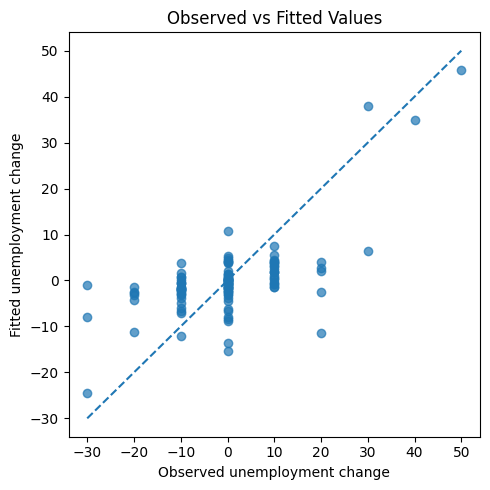

In [3]:
# 拟合值
fitted = model_hac.fittedvalues
actual = y

plt.figure(figsize=(5, 5))
plt.scatter(actual, fitted, alpha=0.7)
plt.plot(
    [actual.min(), actual.max()],
    [actual.min(), actual.max()],
    linestyle="--"
)

plt.xlabel("Observed unemployment change")
plt.ylabel("Fitted unemployment change")
plt.title("Observed vs Fitted Values")

plt.tight_layout()
plt.savefig("pic/observed_vs_fitted.png", dpi=300)
plt.show()


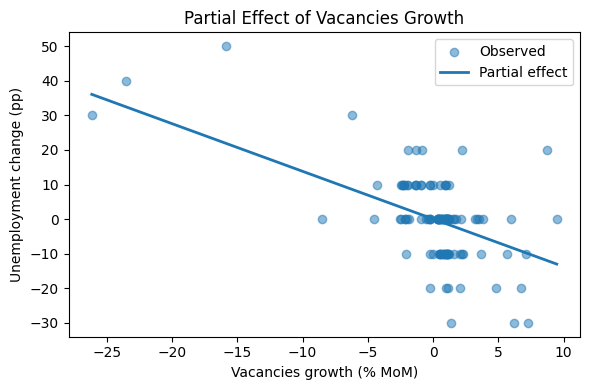

In [4]:
# 构造 vacancies 的变化范围
x_grid = np.linspace(
    df_ts["vacancies_growth"].min(),
    df_ts["vacancies_growth"].max(),
    100
)

# 其他变量固定在均值
X_partial = pd.DataFrame({
    "const": 1.0,
    "vacancies_growth": x_grid,
    "gdp_growth": df_ts["gdp_growth"].mean(),
    "cpih_inflation": df_ts["cpih_inflation"].mean(),
})

y_pred = model_hac.predict(X_partial)

plt.figure(figsize=(6, 4))
plt.scatter(
    df_ts["vacancies_growth"],
    df_ts["unemployment_change"],
    alpha=0.5,
    label="Observed"
)
plt.plot(x_grid, y_pred, linewidth=2, label="Partial effect")

plt.xlabel("Vacancies growth (% MoM)")
plt.ylabel("Unemployment change (pp)")
plt.title("Partial Effect of Vacancies Growth")
plt.legend()

plt.tight_layout()
plt.savefig("pic/partial_effect_vacancies.png", dpi=300)
plt.show()
